In [ ]:
# Run this notebook with  jupyter notebook --NotebookApp.max_buffer_size=12884901888
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("EnsDb.Hsapiens.v86",force=TRUE)
#BiocManager::install(version = "3.14",ask=FALSE)
#BiocManager::install("GenomeInfoDb",force=TRUE)


In [ ]:
1024*1024*1024*12

In [2]:
library(dplyr)
library(ggplot2)
library(EnsDb.Hsapiens.v86)
library(Seurat)
library(Signac)
library(repr)
library(ape)
#sessionInfo()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading req

In [3]:
#sample_name <- "rcmb56-ht"
sample_name <- "rcmb56-pdx"

if (sample_name == 'rcmb56-ht'){
    file = "../RCMB56-ht/cellranger-2.0.0/outs/filtered_feature_bc_matrix"
    frag.file <- "../RCMB56-ht/cellranger-2.0.0/outs/atac_fragments.tsv.gz"
} else if (sample_name == 'rcmb56-pdx'){
    file <- "../RCMB56-pdx/RCMB56-pdx/outs/filtered_feature_bc_matrix"
    frag.file <- "../RCMB56-pdx/RCMB56-pdx/outs/atac_fragments.tsv.gz"
}
tx_data <- Read10X(data.dir = file)

10X data contains more than one type and is being returned as a list containing matrices of each type.



Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

An object of class Seurat 
207903 features across 12869 samples within 2 assays 
Active assay: RNA (36601 features, 0 variable features)
 1 other assay present: ATAC

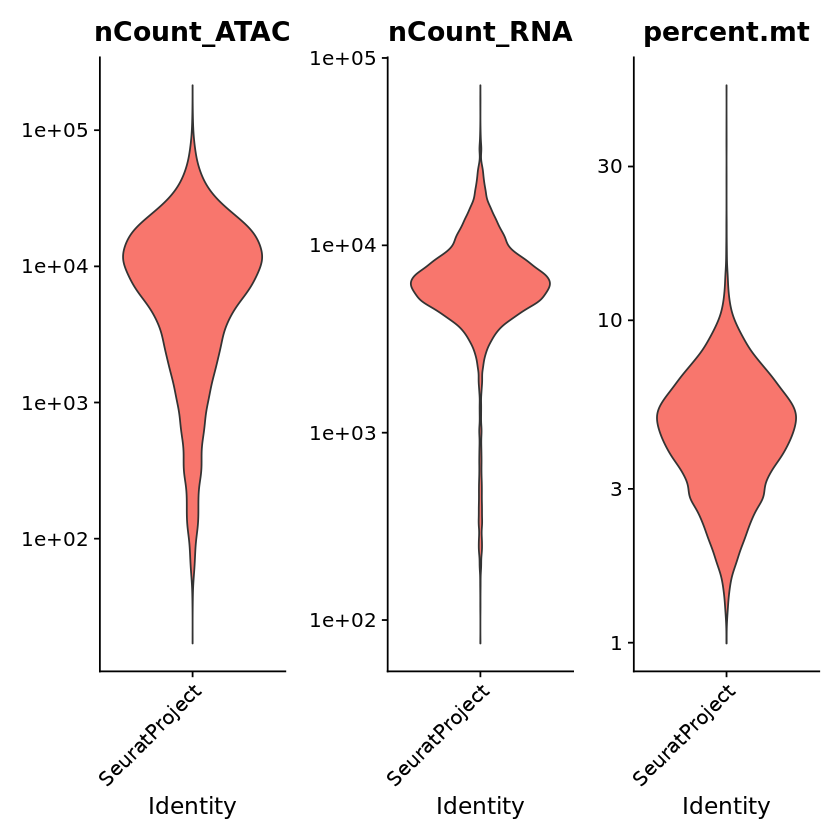

In [4]:
# extract RNA and ATAC data
rna_counts <- tx_data$`Gene Expression`
atac_counts <- tx_data$Peaks
rm(tx_data)

# Create Seurat object
seuratobj <- CreateSeuratObject(counts = rna_counts)
seuratobj[["percent.mt"]] <- PercentageFeatureSet(seuratobj, pattern = "^MT-")

# Now add in the ATAC-seq data
# we'll only use peaks in standard chromosomes
grange.counts <- StringToGRanges(rownames(atac_counts), sep = c(":", "-"))
grange.use <- seqnames(grange.counts) %in% standardChromosomes(grange.counts)
atac_counts <- atac_counts[as.vector(grange.use), ]
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- "hg38"
chrom_assay <- CreateChromatinAssay(
   counts = atac_counts,
   sep = c(":", "-"),
   genome = 'hg38',
   fragments = frag.file,
   min.cells = 10,
   annotation = annotations
 )
seuratobj[["ATAC"]] <- chrom_assay

# QC checks
VlnPlot(seuratobj, features = c("nCount_ATAC", "nCount_RNA","percent.mt"), ncol = 3,
  log = TRUE, pt.size = 0) + NoLegend()
seuratobj

In [5]:
# QC thresholds based on qc plot
if (sample_name == 'rcmb56-ht'){
    seuratobj <- subset(x = seuratobj, subset = 
                        nCount_ATAC < 7e4 &
                        nCount_ATAC > 1e3 &
                        nCount_RNA < 25000 &
                        nCount_RNA > 500 &
                        percent.mt < 10
        )
} else if (sample_name == 'rcmb56-pdx'){
    seuratobj <- subset(x = seuratobj, subset =
                        nCount_ATAC < 7e4 &
                        nCount_ATAC > 1e3 &
                        nCount_RNA < 25000 &
                        nCount_RNA > 1e3 &
                        percent.mt < 10
        )
    # get only human cells.
    xenocell_human_barcodes_file <- "../2021-11-01_xenocell/cellular_barcodes.txt"
    human_barcodes <- read.delim(xenocell_human_barcodes_file, header=FALSE, sep='\n')
    human_barcodes <- human_barcodes$V1
    human_barcodes <- paste0(human_barcodes,"-1")
    seuratobj <- subset(x=seuratobj,cells=human_barcodes)
    rm(human_barcodes)
}
#ht - 4473 -> 2986 cells
#pdx - 12869 -> 10400 cells

In [ ]:
# Dimensionality reduction on RNA data
DefaultAssay(seuratobj) <- "RNA"
seuratobj <- SCTransform(seuratobj, return.only.var.genes = TRUE, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

#seuratobj <- SCTransform(seuratobj, return.only.var.genes = FALSE, verbose = FALSE) %>% RunPCA() %>% RunUMAP(dims = 1:50, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_')

# check PCs against sequencing depth
options(repr.plot.width = 7, repr.plot.height = 7)
DepthCor(seuratobj,reduction='pca')

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):
"iteration limit reached"
Warning message in theta.ml(y = y, mu = fit$fitted):

In [ ]:
seuratobj

In [ ]:
# Dimensionality reduction on ATAC data 
DefaultAssay(seuratobj) <- "ATAC"
seuratobj <- RunTFIDF(seuratobj)
seuratobj <- FindTopFeatures(seuratobj, min.cutoff = 'q0')
seuratobj <- RunSVD(seuratobj)
seuratobj <- RunUMAP(seuratobj, reduction = 'lsi', dims = 2:50, reduction.name = "umap.atac", reduction.key = "atacUMAP_")
# check PCs against sequencing depth
options(repr.plot.width = 7, repr.plot.height = 7)
DepthCor(seuratobj,reduction='lsi')

In [ ]:
# WNN multimodal clustering
seuratobj <- FindMultiModalNeighbors(seuratobj, reduction.list = list("pca", "lsi"), dims.list = list(1:50, 2:50))
seuratobj <- RunUMAP(seuratobj, nn.name = "weighted.nn", reduction.name = "wnn.umap", reduction.key = "wnnUMAP_")
seuratobj <- FindClusters(seuratobj, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

# Plot UMAPs
options(repr.plot.width = 16, repr.plot.height = 6)
p1 <- DimPlot(seuratobj, reduction = "umap.rna", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(seuratobj, reduction = "umap.atac", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(seuratobj, reduction = "wnn.umap", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))

In [ ]:
seuratobj <- BuildClusterTree(seuratobj,graph="wsnn")
ape::plot.phylo(Tool(object=seuratobj, slot='BuildClusterTree'),use.edge.length=FALSE)
ape::plot.phylo(Tool(object=seuratobj, slot='BuildClusterTree'))
# lol high-dimensional space what the fuck

In [ ]:
DefaultAssay(seuratobj) <- "SCT"
markers <- FindAllMarkers(seuratobj)
markers

In [ ]:
write.table(markers,paste(sample_name,'_markers.tsv',sep=""),sep='\t')

## Save various tables

In [ ]:
# Save relevant objects and data tables
saveRDS(seuratobj,paste(sample_name,"_seuratobj.rds",sep=""))

In [ ]:
sample_name <- "rcmb56-pdx"

In [ ]:
seuratobj <- readRDS(paste0(sample_name,"_seuratobj.rds"))
seuratobj

In [ ]:
# Get scaled gene expression
gene = 'DNTTIP2'
#gene = 'ARHGAP29'
#gene = 'KMT2E'
DefaultAssay(seuratobj) <- "SCT"
m <- GetAssayData(seuratobj, slot="data")
library(data.table)
m <- data.table(barcode = names(m[gene, ]),DNTTIP2 = m[gene, ])
write.table(m,paste0(sample_name,'_dnttip2.data.sct.tsv'),sep='\t')

In [ ]:
# save metadata, including cluster identities
write.table(seuratobj[[]],paste(sample_name,'_seurat_metadata.tsv',sep=""),sep='\t')

# save cell embeddings
DefaultAssay(seuratobj) <- "SCT"
write.table(Embeddings(seuratobj, reduction='pca'),paste(sample_name,'_seurat_rna_cell_embeddings.tsv',sep=""),sep='\t')
DefaultAssay(seuratobj) <- "ATAC"
write.table(Embeddings(seuratobj, reduction='lsi'),paste(sample_name,'_seurat_atac_cell_embeddings.tsv',sep=""),sep='\t')
write.table(Embeddings(seuratobj, reduction='wnn.umap'),paste(sample_name,'_seurat_wnn_embeddings',sep=""),sep='\t')

In [ ]:
#DefaultAssay(seuratobj) <- "RNA"
#sce <- as.SingleCellExperiment(seuratobj)
#saveRDS(sce,paste0(sample_name,"_sce.rds"))

In [ ]:
sce

# Dead code

In [ ]:
# WNN multimodal clustering
detailed_clusters <- FindClusters(seuratobj, resolution=2, graph.name = "wsnn", algorithm = 3, verbose = FALSE)

# Plot UMAPs
options(repr.plot.width = 16, repr.plot.height = 6)
p1 <- DimPlot(detailed_clusters, reduction = "umap.rna", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("RNA")
p2 <- DimPlot(detailed_clusters, reduction = "umap.atac", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("ATAC")
p3 <- DimPlot(detailed_clusters, reduction = "wnn.umap", label = TRUE, label.size = 5, repel = TRUE) + ggtitle("WNN")
p1 + p2 + p3 & NoLegend() & theme(plot.title = element_text(hjust = 0.5))

In [ ]:
detailed_clusters <- BuildClusterTree(detailed_clusters,graph="wsnn")
ape::plot.phylo(Tool(object=detailed_clusters, slot='BuildClusterTree'),use.edge.length=FALSE)